# Example usage of segmentation to btrack to napari visualization

This example uses TIF files saved out from segmentation using *stardist3D*, although will work for other segmentation pipelines too.

In [1]:
import glob
import os
import btrack
print('Btrack version', btrack.__version__)
import napari
print('Napari version', napari.__version__)
import numpy as np

from skimage.io import imread
from natsort import natsorted
from tqdm import tqdm
import tifffile as tiff

Btrack version 0.4.2
Napari version 0.4.11


# Load experiment and position list

In [2]:
root_folder = '/home/nathan/data/kraken/commitment/'
expt_IDs = natsorted([ID for ID in os.listdir(root_folder) if 'MK' in ID])
print('Experiment/position list', [(expt,natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])) for expt in expt_IDs])

Experiment/position list [('MK0000', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0000v1', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0001', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0002', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0003', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15'])]


# Manually select one position 

In [3]:
expt = 'MK0002'
pos = 'Pos12'

# Load mask file names

In [4]:
mask_path = os.path.join(root_folder, '{}/{}/{}_cp_masks'.format(expt, pos, pos))
masks = natsorted(glob.glob(os.path.join(mask_path, '*.png')))

# Filter according to channel

In [5]:
gfp_masks = [file for file in masks if 'channel001' in file]
rfp_masks = [file for file in masks if 'channel002' in file]
print("Number of gfp/rfp masks", len(gfp_masks), len(rfp_masks))

Number of gfp/rfp masks 1200 1200


# Load corresponding fluorescence image filenames

In [6]:
image_path = os.path.join(root_folder, '{}/{}/{}_raw'.format(expt, pos, pos))
images = natsorted(glob.glob(os.path.join(image_path, '*.tif')))
gfp_images = [im for im in images if 'channel001' in im]
rfp_images = [im for im in images if 'channel002' in im]
irfp_images = [im for im in images if 'channel003' in im]
print(len(gfp_images), len(rfp_images), len(irfp_images))

1200 1200 1200


# Create stack using a generator

This is useful if you're resource constrained and don't want to load all of the image data, or they are stored in an unusual format. Note that the generator produces a numpy array for each image...

In [7]:
def stack_generator(files):
    """Stack generator"""
    
    for filename in tqdm(files):
        img = imread(filename)
        yield img

In [15]:
gfp_mask_stack = stack_generator(gfp_masks)
rfp_mask_stack = stack_generator(rfp_masks)

gfp_image_stack = stack_generator(gfp_images)
rfp_image_stack = stack_generator(rfp_images)
irfp_image_stack = stack_generator(irfp_images)

100%|█████████▉| 1199/1200 [03:42<00:00,  5.38it/s]


In [9]:
import matplotlib.pyplot as plt

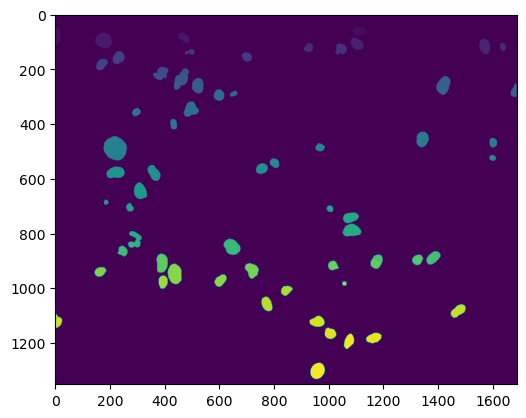

In [10]:
plt.imshow(imread(rfp_masks[0]))
plt.show()

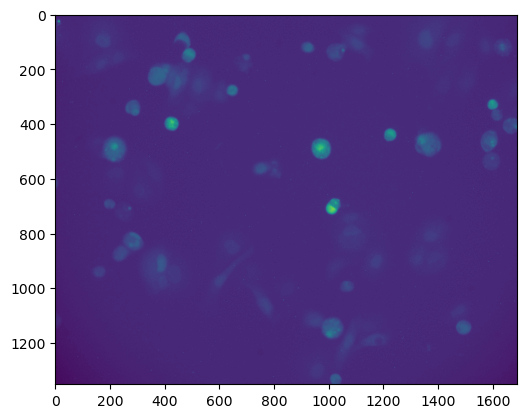

In [11]:
plt.imshow(imread(irfp_images[0]))
plt.show()

## localizing the objects

Now we use a utility function to localise the objects in the segmentation, and also apply anisotropic scaling (using the `scale` option, here the z-values are scaled by 2x). Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

two channel option

### note: if reusing an image stack generator then the generator may need to be reloaded

In [12]:
gfp_obj_from_generator = btrack.utils.segmentation_to_objects(
    gfp_mask_stack, gfp_image_stack,
properties = ('area', 'mean_intensity')
)
rfp_obj_from_generator = btrack.utils.segmentation_to_objects(
    rfp_mask_stack, rfp_image_stack,
    properties = ('area', 'mean_intensity')
)
irfp_obj_from_generator = btrack.utils.segmentation_to_objects(
    rfp_mask_stack, irfp_image_stack,
properties = ('area', 'mean_intensity')
)

[INFO][2021/10/19 01:43:23 PM] Localizing objects from segmentation...
[INFO][2021/10/19 01:43:23 PM] Found intensity_image data
[INFO][2021/10/19 01:43:23 PM] Calculating weighted centroids using intensity_image
 24%|██▍       | 293/1200 [00:23<01:05, 13.91it/s]


 49%|████▉     | 593/1200 [00:49<00:45, 13.37it/s]


 75%|███████▍  | 895/1200 [01:13<00:25, 11.82it/s]


 99%|█████████▉| 1189/1200 [01:39<00:00, 11.88it/s]


100%|██████████| 1200/1200 [01:39<00:00, 12.01it/s]
[INFO][2021/10/19 01:45:03 PM] Objects are of type: <class 'dict'>
[INFO][2021/10/19 01:45:04 PM] ...Found 40156 objects in 1200 frames.
[INFO][2021/10/19 01:45:04 PM] Localizing objects from segmentation...
[INFO][2021/10/19 01:45:04 PM] Found intensity_image data
[INFO][2021/10/19 01:45:04 PM] Calculating weighted centroids using intensity_image
  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 2/1200 [00:00<01:40, 11.98it/s]

  0%|          | 4/1200 [00:00<01:36, 12.37it/s]

  0%|          | 6/1200 [00:00<01:45, 11.29it/s]

  1%|          | 8/1200 [00:00<01:38, 12.10it/s]

  1%|          | 10/1200 [00:00<01:36, 12.39it/s][A

  1%|          | 12/1200 [00:01<01:39, 11.90it/s]

  1%|          | 14/1200 [00:01<01:33, 12.63it/s]

  1%|▏         | 16/1200 [00:01<01:29, 13.25it/s]

  2%|▏         | 18/1200 [00:01<01:27, 13.43it/s]

  2%|▏         | 20/1200 [00:01<01:30, 13.02it/s]

  2%|▏         | 22/1200 [00:01<01:29, 13.17it/s

 22%|██▏       | 260/1200 [00:21<01:12, 12.97it/s]

 22%|██▏       | 262/1200 [00:21<01:11, 13.21it/s]

 22%|██▏       | 264/1200 [00:21<01:09, 13.47it/s]

 22%|██▏       | 266/1200 [00:21<01:09, 13.46it/s]

 22%|██▏       | 268/1200 [00:22<01:10, 13.24it/s]

 22%|██▎       | 270/1200 [00:22<01:16, 12.12it/s]

 23%|██▎       | 272/1200 [00:22<01:14, 12.47it/s]

 23%|██▎       | 274/1200 [00:22<01:15, 12.31it/s]

 23%|██▎       | 276/1200 [00:22<01:11, 12.91it/s]

 23%|██▎       | 278/1200 [00:22<01:09, 13.25it/s]

 23%|██▎       | 280/1200 [00:23<01:12, 12.62it/s]

 24%|██▎       | 282/1200 [00:23<01:18, 11.69it/s]

 24%|██▎       | 284/1200 [00:23<01:22, 11.14it/s]

 24%|██▍       | 286/1200 [00:23<01:22, 11.14it/s]

 24%|██▍       | 288/1200 [00:23<01:17, 11.81it/s]

 24%|██▍       | 290/1200 [00:23<01:16, 11.85it/s]

 24%|██▍       | 292/1200 [00:24<01:16, 11.91it/s]

 24%|██▍       | 294/1200 [00:24<01:10, 12.85it/s]

 25%|██▍       | 296/1200 [00:24<01:10, 12.78it/s]

 25%|██▍    

 45%|████▌     | 541/1200 [00:45<01:06,  9.96it/s]

 45%|████▌     | 543/1200 [00:45<01:02, 10.54it/s]

 45%|████▌     | 545/1200 [00:45<00:59, 11.06it/s]

 46%|████▌     | 547/1200 [00:45<00:58, 11.18it/s]

 46%|████▌     | 549/1200 [00:46<00:55, 11.69it/s]

 46%|████▌     | 551/1200 [00:46<00:55, 11.60it/s]

 46%|████▌     | 553/1200 [00:46<00:55, 11.59it/s]

 46%|████▋     | 555/1200 [00:46<00:54, 11.79it/s]

 46%|████▋     | 557/1200 [00:46<00:56, 11.30it/s]

 47%|████▋     | 559/1200 [00:46<00:53, 11.98it/s]

 47%|████▋     | 561/1200 [00:47<00:53, 11.91it/s]

 47%|████▋     | 563/1200 [00:47<00:52, 12.05it/s]

 47%|████▋     | 565/1200 [00:47<00:52, 12.14it/s]

 47%|████▋     | 567/1200 [00:47<00:49, 12.78it/s]

 47%|████▋     | 569/1200 [00:47<00:50, 12.55it/s]

 48%|████▊     | 571/1200 [00:47<00:52, 11.93it/s]

 48%|████▊     | 573/1200 [00:48<00:50, 12.49it/s]

 48%|████▊     | 575/1200 [00:48<00:50, 12.28it/s]

 48%|████▊     | 577/1200 [00:48<00:51, 12.01it/s]

 48%|████▊  

 69%|██████▊   | 823/1200 [01:10<00:33, 11.12it/s]

 69%|██████▉   | 825/1200 [01:10<00:32, 11.57it/s]

 69%|██████▉   | 827/1200 [01:10<00:33, 11.12it/s]

 69%|██████▉   | 829/1200 [01:11<00:31, 11.69it/s]

 69%|██████▉   | 831/1200 [01:11<00:31, 11.89it/s]

 69%|██████▉   | 833/1200 [01:11<00:49,  7.37it/s]

 70%|██████▉   | 835/1200 [01:11<00:43,  8.30it/s]

 70%|██████▉   | 837/1200 [01:12<00:39,  9.12it/s]

 70%|██████▉   | 839/1200 [01:12<00:37,  9.58it/s]

 70%|███████   | 841/1200 [01:12<00:35, 10.21it/s]

 70%|███████   | 843/1200 [01:12<00:41,  8.59it/s]

 70%|███████   | 844/1200 [01:12<00:42,  8.46it/s]

 70%|███████   | 846/1200 [01:13<00:37,  9.49it/s]

 71%|███████   | 849/1200 [01:13<00:40,  8.64it/s]

 71%|███████   | 851/1200 [01:13<00:36,  9.44it/s]

 71%|███████   | 853/1200 [01:13<00:35,  9.91it/s]

 71%|███████▏  | 855/1200 [01:13<00:32, 10.69it/s]

 71%|███████▏  | 857/1200 [01:14<00:30, 11.15it/s]

 72%|███████▏  | 859/1200 [01:14<00:31, 10.77it/s]

 72%|███████

 91%|█████████ | 1088/1200 [01:36<00:14,  7.79it/s]

 91%|█████████ | 1090/1200 [01:37<00:12,  8.73it/s]

 91%|█████████ | 1092/1200 [01:37<00:11,  9.18it/s]

 91%|█████████ | 1094/1200 [01:37<00:10,  9.68it/s]

 91%|█████████▏| 1096/1200 [01:37<00:10,  9.77it/s]

 92%|█████████▏| 1098/1200 [01:37<00:09, 10.39it/s]

 92%|█████████▏| 1100/1200 [01:38<00:09, 10.72it/s]

 92%|█████████▏| 1102/1200 [01:38<00:09, 10.02it/s]

 92%|█████████▏| 1104/1200 [01:38<00:09, 10.37it/s]

 92%|█████████▏| 1106/1200 [01:38<00:12,  7.46it/s]

 92%|█████████▏| 1108/1200 [01:39<00:11,  8.22it/s]

 92%|█████████▏| 1109/1200 [01:39<00:11,  8.22it/s]

 92%|█████████▎| 1110/1200 [01:39<00:11,  8.13it/s]

 93%|█████████▎| 1112/1200 [01:39<00:09,  9.10it/s]

 93%|█████████▎| 1114/1200 [01:39<00:08,  9.66it/s]

 93%|█████████▎| 1115/1200 [01:39<00:09,  8.98it/s]

 93%|█████████▎| 1117/1200 [01:40<00:08,  9.54it/s]

 93%|█████████▎| 1118/1200 [01:40<00:09,  8.89it/s]

 93%|█████████▎| 1120/1200 [01:40<00:08,  9.38

In [13]:
gfp_obj_from_generator = btrack.utils.segmentation_to_objects(
    gfp_mask_stack, gfp_image_stack,
properties = ('area', 'mean_intensity')
)

[INFO][2021/10/19 02:06:12 PM] Localizing objects from segmentation...
[INFO][2021/10/19 02:06:12 PM] Found intensity_image data
[INFO][2021/10/19 02:06:12 PM] Calculating weighted centroids using intensity_image
  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 2/1200 [00:00<01:00, 19.88it/s]

  0%|          | 4/1200 [00:00<01:01, 19.54it/s]

  1%|          | 7/1200 [00:00<00:57, 20.72it/s]

  1%|          | 10/1200 [00:00<00:55, 21.52it/s][A

  1%|          | 13/1200 [00:00<00:57, 20.62it/s]

  1%|▏         | 16/1200 [00:00<00:55, 21.27it/s]

  2%|▏         | 19/1200 [00:00<00:54, 21.71it/s]

  2%|▏         | 22/1200 [00:01<00:53, 22.02it/s]

  2%|▏         | 25/1200 [00:01<00:53, 22.06it/s]

  2%|▏         | 28/1200 [00:01<00:54, 21.70it/s]

  3%|▎         | 31/1200 [00:01<00:53, 22.00it/s]

  3%|▎         | 34/1200 [00:01<00:54, 21.53it/s]

  3%|▎         | 37/1200 [00:01<00:55, 21.04it/s]

  3%|▎         | 40/1200 [00:01<00:54, 21.41it/s]

  4%|▎         | 43/1200 [00:02<

 34%|███▍      | 409/1200 [00:19<00:36, 21.53it/s]

 34%|███▍      | 412/1200 [00:19<00:36, 21.70it/s]

 35%|███▍      | 415/1200 [00:19<00:35, 22.20it/s]

 35%|███▍      | 418/1200 [00:19<00:35, 22.26it/s]

 35%|███▌      | 421/1200 [00:19<00:36, 21.39it/s]

 35%|███▌      | 424/1200 [00:19<00:38, 20.36it/s]

 36%|███▌      | 427/1200 [00:19<00:36, 21.20it/s]

 36%|███▌      | 430/1200 [00:19<00:35, 21.53it/s]

 36%|███▌      | 433/1200 [00:20<00:35, 21.38it/s]

 36%|███▋      | 436/1200 [00:20<00:34, 21.90it/s]

 37%|███▋      | 439/1200 [00:20<00:34, 22.25it/s]

 37%|███▋      | 442/1200 [00:20<00:34, 22.20it/s]

 37%|███▋      | 445/1200 [00:20<00:34, 21.61it/s]

 37%|███▋      | 448/1200 [00:20<00:35, 20.91it/s]

 38%|███▊      | 451/1200 [00:20<00:36, 20.79it/s]

 38%|███▊      | 454/1200 [00:21<00:36, 20.58it/s]

 38%|███▊      | 457/1200 [00:21<00:34, 21.33it/s]

 38%|███▊      | 460/1200 [00:21<00:33, 21.82it/s]

 39%|███▊      | 463/1200 [00:21<00:34, 21.66it/s]

 39%|███▉   

 69%|██████▉   | 832/1200 [00:38<00:17, 20.81it/s]

 70%|██████▉   | 835/1200 [00:39<00:17, 20.85it/s]

 70%|██████▉   | 838/1200 [00:39<00:17, 21.29it/s]

 70%|███████   | 841/1200 [00:39<00:17, 21.11it/s]

 70%|███████   | 844/1200 [00:39<00:16, 21.30it/s]

 71%|███████   | 847/1200 [00:39<00:17, 20.34it/s]

 71%|███████   | 850/1200 [00:39<00:16, 20.60it/s]

 71%|███████   | 853/1200 [00:39<00:16, 21.07it/s]

 71%|███████▏  | 856/1200 [00:40<00:16, 21.04it/s]

 72%|███████▏  | 859/1200 [00:40<00:15, 21.34it/s]

 72%|███████▏  | 862/1200 [00:40<00:16, 20.51it/s]

 72%|███████▏  | 865/1200 [00:40<00:16, 20.75it/s]

 72%|███████▏  | 868/1200 [00:40<00:16, 20.28it/s]

 73%|███████▎  | 871/1200 [00:40<00:15, 20.66it/s]

 73%|███████▎  | 874/1200 [00:40<00:15, 20.93it/s]

 73%|███████▎  | 877/1200 [00:41<00:15, 20.78it/s]

 73%|███████▎  | 880/1200 [00:41<00:15, 21.07it/s]

 74%|███████▎  | 883/1200 [00:41<00:14, 21.28it/s]

 74%|███████▍  | 886/1200 [00:41<00:14, 21.14it/s]

 74%|███████

In [16]:
rfp_obj_from_generator = btrack.utils.segmentation_to_objects(
    rfp_mask_stack, rfp_image_stack,
    properties = ('area', 'mean_intensity')
)

[INFO][2021/10/19 02:08:53 PM] Localizing objects from segmentation...
[INFO][2021/10/19 02:08:53 PM] Found intensity_image data
[INFO][2021/10/19 02:08:53 PM] Calculating weighted centroids using intensity_image
 29%|██▉       | 352/1200 [00:18<00:43, 19.37it/s]


 57%|█████▋    | 687/1200 [00:36<00:28, 17.83it/s]


 82%|████████▎ | 990/1200 [00:54<00:13, 15.45it/s]


100%|██████████| 1200/1200 [01:09<00:00, 17.31it/s]
[INFO][2021/10/19 02:10:02 PM] Objects are of type: <class 'dict'>
[INFO][2021/10/19 02:10:04 PM] ...Found 152904 objects in 1200 frames.


In [12]:
irfp_obj_from_generator = btrack.utils.segmentation_to_objects(
    rfp_mask_stack, irfp_image_stack,
properties = ('area', 'mean_intensity')
)

[INFO][2021/10/19 02:05:01 PM] Localizing objects from segmentation...
[INFO][2021/10/19 02:05:01 PM] Found intensity_image data
[INFO][2021/10/19 02:05:01 PM] Calculating weighted centroids using intensity_image
 29%|██▉       | 352/1200 [00:18<00:42, 20.18it/s]


 58%|█████▊    | 695/1200 [00:36<00:28, 17.99it/s]


 83%|████████▎ | 998/1200 [00:55<00:13, 15.38it/s]


100%|██████████| 1200/1200 [01:09<00:00, 17.25it/s]
[INFO][2021/10/19 02:06:11 PM] Objects are of type: <class 'dict'>
[INFO][2021/10/19 02:06:12 PM] ...Found 152904 objects in 1200 frames.


In [29]:
# inspect the first object
irfp_obj_from_generator[0]

{'ID': 0, 'x': 14.06097721585671, 'y': 26.66113525615699, 'z': 0.0, 't': 0, 'dummy': False, 'states': 0, 'label': 5, 'prob': 0.0, 'area': 284, 'mean_intensity': 80.20774647887323}

## run btrack with the objects

We will use the objects from the generator here.

In [31]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file('/home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_new.json')
    tracker.max_search_radius = 10

    # append the objects to be tracked
    #tracker.append(gfp_obj_from_arr) #obj_from_generator)
    tracker.append(irfp_obj_from_generator)

    # set the volume
    tracker.volume=((0, 1688),(0, 1352),(-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(os.path.join(root_folder,expt, pos, 'irfp_rfp_tracks.h5'), obj_type='obj_type_2')

    # get the tracks in a format for napari visualization
#     #gfp_data, gfp_properties, gfp_graph = tracker.to_napari(ndim=2)
    
#     gfp_tracks = tracker.tracks

    irfp_data, irfp_properties, irfp_graph = tracker.to_napari(ndim=2)
    
    irfp_tracks = tracker.tracks

[INFO][2021/10/20 12:46:12 PM] Loaded btrack: /home/nathan/src/btrack/btrack/libs/libtracker.so
[INFO][2021/10/20 12:46:12 PM] btrack (v0.4.2) library imported
[INFO][2021/10/20 12:46:12 PM] Setting max XYZ search radius to: 100
[INFO][2021/10/20 12:46:12 PM] Starting BayesianTracker session
[INFO][2021/10/20 12:46:12 PM] Loading configuration file: /home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/cell_config.json
[INFO][2021/10/20 12:46:12 PM] Loading motion model: b'cell_motion'
[INFO][2021/10/20 12:46:12 PM] Setting max XYZ search radius to: 10
[INFO][2021/10/20 12:46:12 PM] Objects are of type: <class 'list'>
[INFO][2021/10/20 12:46:13 PM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2021/10/20 12:46:13 PM] Starting tracking... 
[INFO][2021/10/20 12:46:13 PM] Tracking objects in frames 0 to 99 (of 1200)...
[INFO][2021/10/20 12:46:13 PM]  - Timing (Bayesian updates: 0.71ms, Linking: 0.18ms)
[INFO][2021/10/20 12:46:13 PM]  - Probabilities (Link: 0

# testnig different params out

In [32]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file('/home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_scribble_sparse.json')
    tracker.max_search_radius = 10

    # append the objects to be tracked
    #tracker.append(gfp_obj_from_arr) #obj_from_generator)
    tracker.append(irfp_obj_from_generator)

    # set the volume
    tracker.volume=((0, 1600),(0, 1200),(-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(os.path.join(root_folder,expt, pos, 'irfp_rfp_tracks_v[MDCK_config_scribble_sparse].h5'), obj_type='obj_type_2')

    # get the tracks in a format for napari visualization
#     #gfp_data, gfp_properties, gfp_graph = tracker.to_napari(ndim=2)
    
#     gfp_tracks = tracker.tracks

    irfp_data, irfp_properties, irfp_graph = tracker.to_napari(ndim=2)
    
    irfp_tracks = tracker.tracks

[INFO][2021/10/20 12:46:58 PM] Loaded btrack: /home/nathan/src/btrack/btrack/libs/libtracker.so
[INFO][2021/10/20 12:46:58 PM] btrack (v0.4.2) library imported
[INFO][2021/10/20 12:46:58 PM] Setting max XYZ search radius to: 100
[INFO][2021/10/20 12:46:58 PM] Starting BayesianTracker session
[INFO][2021/10/20 12:46:58 PM] Loading configuration file: /home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_scribble_sparse.json
[INFO][2021/10/20 12:46:58 PM] Loading motion model: b'MDCK_motion'
[INFO][2021/10/20 12:46:58 PM] Setting max XYZ search radius to: 10
[INFO][2021/10/20 12:46:58 PM] Objects are of type: <class 'list'>
[INFO][2021/10/20 12:46:58 PM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2021/10/20 12:46:58 PM] Starting tracking... 
[INFO][2021/10/20 12:46:58 PM] Tracking objects in frames 0 to 99 (of 1200)...
[INFO][2021/10/20 12:46:58 PM]  - Timing (Bayesian updates: 0.70ms, Linking: 0.17ms)
[INFO][2021/10/20 12:46:58 PM]  - Probab

In [33]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file('/home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_wildtype_dense.json')
    tracker.max_search_radius = 10

    # append the objects to be tracked
    #tracker.append(gfp_obj_from_arr) #obj_from_generator)
    tracker.append(irfp_obj_from_generator)

    # set the volume
    tracker.volume=((0, 1600),(0, 1200),(-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(os.path.join(root_folder,expt, pos, 'irfp_rfp_tracks_v[MDCK_config_wildtype_dense].h5'), obj_type='obj_type_2')

    # get the tracks in a format for napari visualization
#     #gfp_data, gfp_properties, gfp_graph = tracker.to_napari(ndim=2)
    
#     gfp_tracks = tracker.tracks

    irfp_data, irfp_properties, irfp_graph = tracker.to_napari(ndim=2)
    
    irfp_tracks = tracker.tracks

[INFO][2021/10/20 12:48:07 PM] Loaded btrack: /home/nathan/src/btrack/btrack/libs/libtracker.so
[INFO][2021/10/20 12:48:07 PM] btrack (v0.4.2) library imported
[INFO][2021/10/20 12:48:07 PM] Setting max XYZ search radius to: 100
[INFO][2021/10/20 12:48:07 PM] Starting BayesianTracker session
[INFO][2021/10/20 12:48:07 PM] Loading configuration file: /home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_wildtype_dense.json
[INFO][2021/10/20 12:48:07 PM] Loading motion model: b'MDCK_motion'
[INFO][2021/10/20 12:48:07 PM] Setting max XYZ search radius to: 10
[INFO][2021/10/20 12:48:07 PM] Objects are of type: <class 'list'>
[INFO][2021/10/20 12:48:07 PM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2021/10/20 12:48:07 PM] Starting tracking... 
[INFO][2021/10/20 12:48:07 PM] Tracking objects in frames 0 to 99 (of 1200)...
[INFO][2021/10/20 12:48:08 PM]  - Timing (Bayesian updates: 0.70ms, Linking: 0.17ms)
[INFO][2021/10/20 12:48:08 PM]  - Probabi

In [23]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker usi#gfp_data, gfp_properties, gfp_graph = tracker.to_napari(ndim=2)
    
#     gfp_tracks = tracker.tracksng a config file
    tracker.configure_from_file('/home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_new.json')
    tracker.max_search_radius = 10

    # append the objects to be tracked
    #tracker.append(rfp_obj_from_arr) #obj_from_generator)
    tracker.append(gfp_obj_from_generator)

    # set the volume
    tracker.volume=((0, 1688),(0, 1352),(-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(os.path.join(root_folder, expt, pos, 'gfp_tracks.h5'), obj_type='obj_type_1')

    # get the tracks in a format for napari visualization
    gfp_data, gfp_properties, gfp_graph = tracker.to_napari(ndim=2)
    
    gfp_tracks = tracker.tracks

[INFO][2021/10/19 02:16:21 PM] Loaded btrack: /home/nathan/src/btrack/btrack/libs/libtracker.so
[INFO][2021/10/19 02:16:21 PM] btrack (v0.4.2) library imported
[INFO][2021/10/19 02:16:21 PM] Setting max XYZ search radius to: 100
[INFO][2021/10/19 02:16:21 PM] Starting BayesianTracker session
[INFO][2021/10/19 02:16:21 PM] Loading configuration file: /home/nathan/analysis/cell-comp-analysis/BayesianTracker/models/MDCK_config_new.json
[INFO][2021/10/19 02:16:21 PM] Loading motion model: b'MDCK_motion_Kristina'
[INFO][2021/10/19 02:16:21 PM] Setting max XYZ search radius to: 10
[INFO][2021/10/19 02:16:21 PM] Objects are of type: <class 'list'>
[INFO][2021/10/19 02:16:21 PM] Set volume to ((0, 1688), (0, 1352), (-100000.0, 100000.0))
[INFO][2021/10/19 02:16:21 PM] Starting tracking... 
[INFO][2021/10/19 02:16:21 PM] Tracking objects in frames 0 to 99 (of 1200)...
[INFO][2021/10/19 02:16:21 PM]  - Timing (Bayesian updates: 0.06ms, Linking: 0.05ms)
[INFO][2021/10/19 02:16:21 PM]  - Probabili

# load tracks from pre-config h5 files

In [7]:
tracks_path = natsorted(glob.glob('/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/{}/{}/*.h5'.format(expt, pos)))
[(i, name) for i,name in enumerate(tracks_path)]

[(0,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/_irfp_tracks.h5'),
 (1,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_21_05_57_38_PM.h5'),
 (2,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5'),
 (3,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5'),
 (4,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_21_05_57_45_PM.h5'),
 (5,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5')]

In [8]:
gfp_tracks = tracks_path[2]
rfp_tracks = tracks_path[5]
irfp_tracks = tracks_path[3]

with btrack.dataio.HDF5FileHandler(irfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    irfp_tracks = hdf.tracks
# with btrack.dataio.HDF5FileHandler(gfp_tracks, 'r', obj_type = "obj_type_3") as hdf:
#     wt_tracks = hdf.tracks
# with btrack.dataio.HDF5FileHandler(rfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
#     scr_tracks = hdf.tracks
# print("Tracks loaded")

[INFO][2021/05/30 04:16:36 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5...
[INFO][2021/05/30 04:16:36 PM] Loading tracks/obj_type_2
[INFO][2021/05/30 04:16:36 PM] Loading objects/obj_type_2 (551730, 5) (551730 filtered: None)
[INFO][2021/05/30 04:16:42 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5


# Inspect irfp tracks

In [25]:
irfp_tracks[3]

OrderedDict([('ID', 50), ('t', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), ('x', [177.72885614724902, 171.65363782096352, 171.930967460876, 169.13897699030792, 172.81919312109918, 174.84669589310118, 175.9250872461929, 176.76107060039672, 178.35275331624123, 183.71627740442878, 182.59254921767896, 183.62075688453425, 186.19035367240545, 188.87401168689107, 186.1882007431325, 186.50204868643047, 185.4112868401166, 188.22489191709406, 185.52658590910045, 183.56543361934234, 186.91191407661262, 185.3068616057359, 187.423380437661, 184.34234607822125, 188.66385304287036, 181.20991585389174]), ('y', [96.37088927054744, 91.58724301825238, 86.59012767668644, 78.93259272789669, 73.49792892101837, 68.06702950290563, 63.971152102973164, 61.044321515380105, 55.70735146583435, 53.435589952627524, 49.15529308593598, 46.113389079742404, 44.214376597493555, 42.45554503873904, 42.157539766243175, 42.68366419071408, 42.72417143474037, 43.77906582460899, 43.50178079889055, 45.08762433112185, 47.927547302249245, 50.805074062401516, 52.402152194323406, 53.839028617755865, 53.73518242107053, 56.89989003633582]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.6797909102777968, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 50), ('root', 50), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('area', array([2697., 2692., 2744., 2786., 2762.,   nan, 2788., 2858., 2865.,
       2886., 2857., 2872., 2809., 2789., 2931., 2872., 2918., 2978.,
       3000., 3041., 3048., 3214., 3277., 3386., 3384., 3278.])), ('mean_intensity', array([67.14163886, 66.04197623, 65.25      , 64.84673367, 64.50687907,
               nan, 63.31133429, 62.61896431, 62.62478185, 62.9036729 ,
       63.06230312, 63.04247911, 63.23317907, 63.26174256, 63.08188332,
       63.56406685, 63.48869088, 63.37944929, 63.45466667, 63.54291352,
       63.5675853 , 63.18357187, 63.3796155 , 63.38511518, 62.56146572,
       63.80719951]))])

In [26]:
### filter tracks the same way i filter the glimpses
#focal_time_range = (0, 800) ### this particular expt stays in focus in this time range
long_tracks = [track for track in irfp_tracks if len(track) > 200]

### filter tracks that spend a lot of time out of focus
#tracks = [track for track in long_tracks if track.t[-1] < focal_time_range[1]]

In [27]:
long_tracks

[OrderedDict([('ID', 359), ('t', [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 

# add image layers

### compile stacks if necessary

In [ ]:
### compile stacks first if necessary 
root_folder = os.path.dirname(PATH)
pos = os.path.basename(root_folder)
### make stack folder if necessary
output_dir = os.path.join(root_folder,pos+'_stacks')
os.mkdir(output_dir) if os.path.exists(output_dir) == False else print(output_dir, 'already exists')
### count number of channels
raw_file_dir = os.path.join(root_folder, pos+'_raw')
file_list = natsorted(os.listdir(raw_file_dir))
channels = list(set([fn.split('channel')[1][0:3] for fn in file_list]))
for channel in ['000', '001', '002']:#channels:
    channel_file_list = natsorted([fn for fn in os.listdir(raw_file_dir) if 'channel'+channel in fn])
    stack = []
    for file in tqdm(channel_file_list):
        file = os.path.join(raw_file_dir, file)
        tif = np.array(tiff.imread(file),dtype=np.uint8)
        ### crop??
#         tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
#         tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
        stack.append(tif)
    stack = np.stack(stack,axis=0)
    with tiff.TiffWriter(os.path.join(output_dir,'channel{}.tif'.format(channel)),imagej=True) as output_file:
        output_file.save(stack)
    print('channel',channel, 'saved out')
    

In [19]:
#image_path = output_dir#'/home/nathan/data/kraken/pcna/MK0000/Pos15/stacks'
image_path = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/{}/{}/{}_stacks'.format(expt, pos, pos)
image_paths = natsorted(glob.glob(os.path.join(image_path, '*.tif')))
[(i, name) for i,name in enumerate(image_paths)]

[(0,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/Pos15_stacks/channel000.tif'),
 (1,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/Pos15_stacks/channel001.tif'),
 (2,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/Pos15_stacks/channel002.tif'),
 (3,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/Pos15_stacks/channel003.tif')]

In [20]:
irfp = imread(image_paths[3])
#rfp = imread(image_paths[2])

## visualize with napari

Note that we also set the scale of the images here to account for the anisotropy.

In [22]:
viewer = napari.Viewer()
# viewer.add_labels(gfp_stack)#, scale=(1., 1., 1.), name='Segmentation')
#viewer.add_labels(rfp_stack)#, scale=(1., 1., 1.), name='Segmentation')
#viewer.add_tracks(gfp_data, properties=gfp_properties, graph=gfp_graph, name='GFP Tracks')
#viewer.add_tracks(irfp_tracks)#, properties=rfp_properties, graph=rfp_graph, name='RFP Tracks')
# viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "magenta")
viewer.add_image(irfp, name="irfp", blending = "additive", colormap = "cyan")
    
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')